# Double-b Tagger BDT Training and Evaluation
Formatted and Structured Notebook

In [1]:

import uproot
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.utils import shuffle


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [9]:

train_directory = "~/Desktop/DoubleB/train_data/"
test_directory = "~/Desktop/DoubleB/test_data/"

features = [
    'fj_tau1', 'fj_tau2', 'fj_tau3', 'fj_tau21', 'fj_tau32',
    'fj_nSV', 'fj_jetNTracks',
    'fj_sdsj1_pt', 'fj_sdsj1_csv', 'fj_sdsj2_pt', 'fj_sdsj2_csv',
    'fj_z_ratio',
    'fj_tau_vertexEnergyRatio_0', 'fj_tau_vertexEnergyRatio_1',
    'fj_tau_vertexMass_0', 'fj_tau_vertexMass_1',
    'fj_trackSip2dSigAboveBottom_0', 'fj_trackSip2dSigAboveBottom_1',
    'fj_trackSip2dSigAboveCharm_0',
    'fj_trackSipdSig_0', 'fj_trackSipdSig_0_0', 'fj_trackSipdSig_0_1',
    'fj_trackSipdSig_1', 'fj_trackSipdSig_1_0', 'fj_trackSipdSig_1_1',
    'fj_trackSipdSig_2', 'fj_trackSipdSig_3',
    'fj_tau_flightDistance2dSig_0', 'fj_tau_flightDistance2dSig_1',
    'fj_tau_vertexDeltaR_0',
    'fj_tau0_trackEtaRel_0', 'fj_tau0_trackEtaRel_1', 'fj_tau0_trackEtaRel_2',
    'fj_tau1_trackEtaRel_0', 'fj_tau1_trackEtaRel_1', 'fj_tau1_trackEtaRel_2',
    'fj_ptDR', 'fj_relptdiff', 'fj_sdn2',
    'fj_sdsj1_axis1', 'fj_sdsj1_axis2', 'fj_sdsj1_eta', 'fj_sdsj1_mass', 'fj_sdsj1_mult', 'fj_sdsj1_phi', 'fj_sdsj1_ptD',
    'fj_sdsj2_axis1', 'fj_sdsj2_axis2', 'fj_sdsj2_eta', 'fj_sdsj2_mass', 'fj_sdsj2_mult', 'fj_sdsj2_phi', 'fj_sdsj2_ptD'
]


spectators = ['fj_sdmass', 'fj_pt']
labels = ['fj_isQCD*sample_isQCD', 'fj_isH*fj_isBB']


In [10]:

def load_root_file(file_path, features, spectators, labels):
    with uproot.open(file_path) as file:
        tree = file["deepntuplizer/tree"]
        branches = features + spectators + ["sample_isQCD", "fj_isQCD", "fj_isH", "fj_isBB"]
        arrays = tree.arrays(branches, library="np")
        df = pd.DataFrame({key: arrays[key] for key in arrays.keys()})
        df["is_signal"] = df["fj_isH"] * df["fj_isBB"]
    return df


In [11]:

def load_data(directory):
    directory = os.path.expanduser(directory)
    files = glob.glob(directory + "*.root")
    dfs = []
    for f in files:
        try:
            df = load_root_file(f, features, spectators, labels)
            dfs.append(df)
        except Exception as e:
            print(f"Skipping {f} due to error: {e}")
    data = pd.concat(dfs, ignore_index=True)
    data = data[(data['fj_sdmass'] > 40) & (data['fj_sdmass'] < 200) & (data['fj_pt'] > 350) & (data['fj_pt'] < 2000)]
    return shuffle(data, random_state=42)

train_data = load_data(train_directory)
test_data = load_data(test_directory)

X_train = train_data[features]
y_train = train_data["is_signal"]
X_test = test_data[features]
y_test = test_data["is_signal"]


Skipping /Users/apple/Desktop/DoubleB/train_data/ntuple_merged_37.root due to error: expected Chunk of length 139,
received 0 bytes from FSSpecSource
for file path /Users/apple/Desktop/DoubleB/train_data/ntuple_merged_37.root
Skipping /Users/apple/Desktop/DoubleB/train_data/ntuple_merged_84.root due to error: expected Chunk of length 139,
received 0 bytes from FSSpecSource
for file path /Users/apple/Desktop/DoubleB/train_data/ntuple_merged_84.root
Skipping /Users/apple/Desktop/DoubleB/train_data/ntuple_merged_72.root due to error: expected Chunk of length 139,
received 0 bytes from FSSpecSource
for file path /Users/apple/Desktop/DoubleB/train_data/ntuple_merged_72.root
Skipping /Users/apple/Desktop/DoubleB/train_data/ntuple_merged_22.root due to error: expected Chunk of length 139,
received 0 bytes from FSSpecSource
for file path /Users/apple/Desktop/DoubleB/train_data/ntuple_merged_22.root


In [12]:

model = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1,
    reg_lambda=3,
    min_child_weight=2,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train, y_train)


/Users/apple/Desktop/DoubleB/train_data/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:45:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


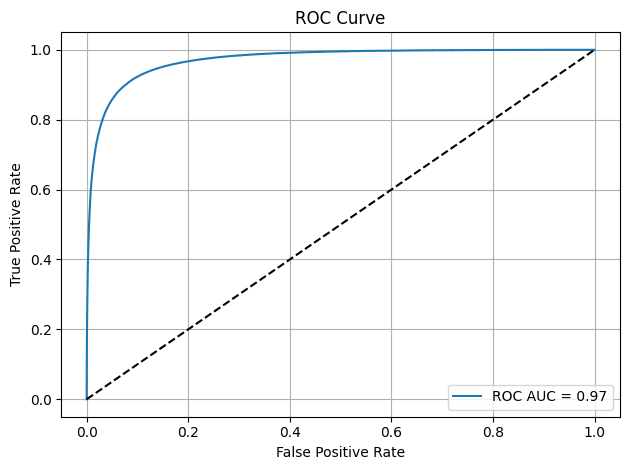

In [36]:
y_score = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()


plt.savefig('feature_plots/ROC_Curve.png')
plt.show()
plt.close()


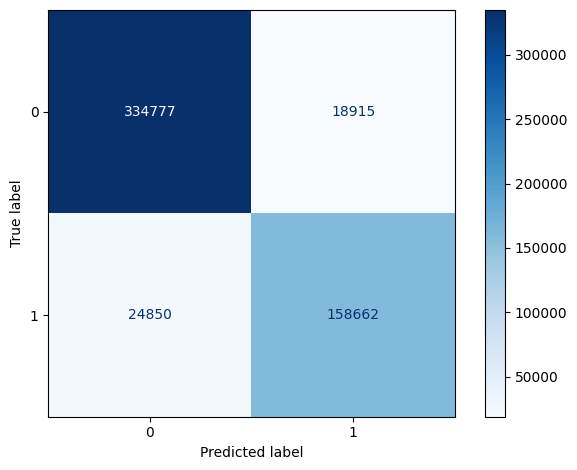

In [32]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Blues")
plt.tight_layout()
plt.savefig('feature_plots/ConfusionMatrix.png')
plt.show()
plt.close()


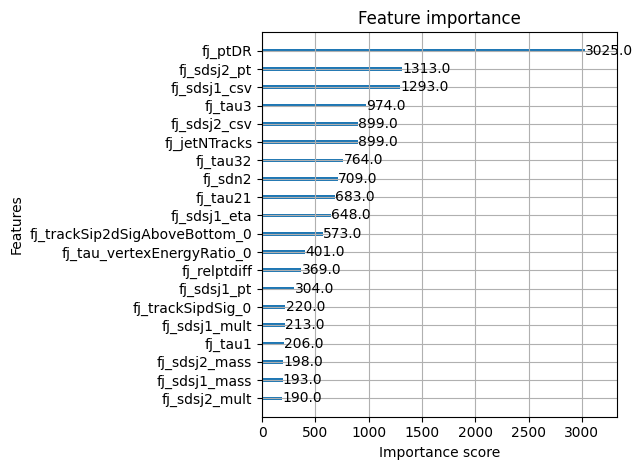

In [25]:

xgb.plot_importance(model, max_num_features=20)
plt.tight_layout()
plt.savefig('feature_plots/FeatureImportance.png')
plt.show()
plt.close()


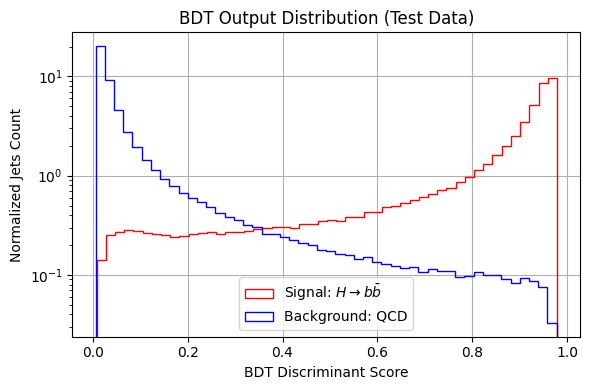

In [30]:
plt.figure(figsize=(6, 4))

plt.hist(y_score[y_test == 1], bins=50, density=True, histtype='step',
         label=r'Signal: $H \to b\bar{b}$', color='red', linewidth=1)

plt.hist(y_score[y_test == 0], bins=50, density=True, histtype='step',
         label='Background: QCD', color='blue', linewidth=1)

plt.yscale('log')
plt.xlabel('BDT Discriminant Score')
plt.ylabel('Normalized Jets Count')
plt.title('BDT Output Distribution (Test Data)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('feature_plots/BDT_Discriminant.png')
plt.show()

In [34]:

for feat in features:
    plt.figure()
    sig = train_data[train_data["is_signal"] == 1][feat]
    bkg = train_data[train_data["is_signal"] == 0][feat]
    plt.hist(sig, bins=50, density=True, histtype='step', label='Signal', color='red')
    plt.hist(bkg, bins=50, density=True, histtype='step', label='Background', color='blue')
    plt.xlabel(feat)
    plt.ylabel("Normalized Count")
    plt.legend()
    plt.grid()
    plt.savefig('feature_plots/{feat}_distribution.png')
    plt.close()


In [35]:


# Ensure the directory exists
os.makedirs('distribution_plots', exist_ok=True)

for feat in features:
    plt.figure(figsize=(6,4))
    
    sig = train_data[train_data["is_signal"] == 1][feat].dropna()
    bkg = train_data[train_data["is_signal"] == 0][feat].dropna()
    
    if sig.empty or bkg.empty:
        print(f"Skipping {feat} — empty signal or background after filtering")
        continue
    
    bins = np.histogram_bin_edges(pd.concat([sig, bkg]), bins=50)

    plt.hist(sig, bins=bins, density=True, histtype='step', label='Signal', color='red')
    plt.hist(bkg, bins=bins, density=True, histtype='step', label='Background', color='blue')
    plt.xlabel(feat)
    plt.ylabel("Normalized Count")
    plt.title(f'Distribution of {feat}')
    plt.legend()
    plt.grid()
    plt.tight_layout()

    plt.savefig(f'distribution_plots/{feat}_distribution.png')
    plt.close()
